In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gzip
import pickle
from collections import defaultdict
import operator
import string
from tqdm.notebook import tqdm
import torch
import copy
import matplotlib.pyplot as plt

In [2]:
def parse(path):
    g = open(path, 'r')
    for l in g:
        yield eval(l)

data = list(parse("lthing_data/reviews.json"))
relationships = [l.replace("\n", "").split(" ") for l in open("lthing_data/edges.txt").readlines()]

In [3]:
data_new = []

for d in tqdm(data):
    if "stars" in d and "unixtime" in d and d["unixtime"] != None:
        data_new.append(d)
data = data_new[:100000]

for d in data:
    if not "unixtime" in d or d["unixtime"] == None:
        print("uh oh")
        
data.sort(key=lambda x: x["unixtime"])

# data.sort(reverse=True, key = lambda x: x["unixtime"])
print(data[0])
print(relationships[0])
print(len(data))

  0%|          | 0/1707070 [00:00<?, ?it/s]

{'work': '4639952', 'flags': [], 'unixtime': -86400, 'stars': 2.0, 'nhelpful': 0, 'time': 'Dec 31, 1969', 'comment': 'De eerste poort van het loolandre is geopend voor de galactische vloot. Ook voor het passeren van de tweede poort moet een proef worden afgelegd. Het presenteert zich aan de Terranen in de vorm van een afgrond onder de zwarte zon... ', 'user': 'janaloog'}
['Rodo', 'anehan']
100000


In [4]:
# Data:
userItemRating = {}
userItemsDict = {}
usersPerItem = defaultdict(set) # Maps an item to the users who rated it
itemsPerUser = defaultdict(set) # Maps a user to the items that they rated

for read in tqdm(data):
    uid, bid = read['user'], read['work']
    if "stars" in read:
        userItemRating[(uid, bid)] = read['stars']
    usersPerItem[bid].add(uid)
    itemsPerUser[uid].add(bid)
    userItemsDict[(uid, bid)] = read
    
def cosine_similarity(v1, v2):
    denom = (np.linalg.norm(v1) * np.linalg.norm(v2))
    if denom == 0:
        return 0
    else:
        return np.dot(v1, v2) / denom
    
# find similarity between users on the basis of the ratings they give to books
def user_similarity(u1, u2):
    u1_books = itemsPerUser[u1]
    u2_books = itemsPerUser[u2]
    all_books = u1_books.union(u2_books)
    u1_ratings = []
    u2_ratings = []
    for b in all_books:
        if (u1, b) in userItemRating:
            u1_ratings.append(userItemRating[(u1, b)])
        else:
            u1_ratings.append(0)
        if (u2, b) in userItemRating:
            u2_ratings.append(userItemRating[(u2, b)])
        else:
            u2_ratings.append(0)
    return cosine_similarity(u1_ratings, u2_ratings)

# Relationships:
usersPerUser = defaultdict(set) # Maps an item to the users who rated it
for relationship in tqdm(relationships):
    u1, u2 = relationship
    userSim = user_similarity(u1, u2)
    usersPerUser[u1].add((userSim, u2))
    usersPerUser[u2].add((userSim, u1))
    
for u in usersPerUser:
    usersPerUser[u] = list(usersPerUser[u])
    usersPerUser[u].sort(reverse=True)

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/219790 [00:00<?, ?it/s]

In [5]:
train_split = int(0.9 * len(data))
train = data[:train_split]
val = data[train_split:]

### N-Grams

In [6]:
unigrams = {}
bigrams ={}

for d in tqdm(train):
    review = d["comment"].lower().translate(str.maketrans('', '', string.punctuation))
    d_unigrams = review.split()
#     d_bigrams = list(zip(d_unigrams[:-1], d_unigrams[1:]))
    
    for ug in d_unigrams:
        if ug in unigrams:
            unigrams[ug] += 1
        else:
            unigrams[ug] = 1
            
#     for bg in d_bigrams:
#         if bg in bigrams:
#             bigrams[bg] += 1
#         else:
#             bigrams[bg] = 1
            
list_unigrams = [(k, v) for k, v in tqdm(unigrams.items())]
list_unigrams.sort(reverse=True, key=operator.itemgetter(1))
unigrams = [k for k, v in list_unigrams]
ugId = dict(zip(unigrams, range(len(unigrams))))



# list_bigrams = [(k, v) for k, v in tqdm(bigrams.items())]
# list_bigrams .sort(reverse=True, key=operator.itemgetter(1))
# bigrams = [k for k, v in list_bigrams]
# bgId = dict(zip(bigrams, range(len(bigrams))))

# list_unigrams_bigrams = list_unigrams + list_bigrams
# list_unigrams_bigrams.sort(reverse=True, key=operator.itemgetter(1))
# unigrams_bigrams = [k for k, v in list_unigrams_bigrams]
# ugbgId = dict(zip(unigrams_bigrams, range(len(unigrams_bigrams))))

# with open('unigrams.pickle', 'wb') as handle:
#     pickle.dump(unigrams, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('ugId.pickle', 'wb') as handle:
#     pickle.dump(ugId, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# with open('bigrams.pickle', 'wb') as handle:
#     pickle.dump(bigrams, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('bgId.pickle', 'wb') as handle:
#     pickle.dump(bgId, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('unigrams_bigrams.pickle', 'wb') as handle:
#     pickle.dump(unigrams_bigrams, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('ugbgId.pickle', 'wb') as handle:
#     pickle.dump(ugbgId, handle, protocol=pickle.HIGHEST_PROTOCOL)

  0%|          | 0/90000 [00:00<?, ?it/s]

  0%|          | 0/279887 [00:00<?, ?it/s]

In [7]:

N=500
unigrams_set = set(unigrams[:N])

unigram_feats = {}
for datum in tqdm(train):
    work = datum["work"]
    if work in unigram_feats:
        feat = unigram_feats[work]
    else:
        feat = ([0] * N)
        feat.append(1)
    review = datum["comment"].lower().translate(str.maketrans('', '', string.punctuation))
    d_unigrams = review.split()
    for ug in d_unigrams:
        if ug in unigrams_set:
            index = ugId[ug]
            feat[index] += 1
    unigram_feats[work] = feat


  0%|          | 0/90000 [00:00<?, ?it/s]

In [8]:

length = -1
count = 0
for t in tqdm(train):
    ug = t["work"]
    if length == -1:
        length = len(unigram_feats[ug])
        continue
    else:
        if length != len(unigram_feats[ug]):
            print(f"length {length} != {len(unigram_feats[ug])}")
            
print(len(unigram_feats[ug]))

  0%|          | 0/90000 [00:00<?, ?it/s]

501


In [9]:
userRatingAverages = {}
for t in tqdm(train):
    if t["user"]  in userRatingAverages:
        total, count = userRatingAverages[t["user"]]
        total += t["stars"]
        count += 1
        userRatingAverages[t["user"]] = (total, count)
    else:
        total = t["stars"]
        count = 1
        userRatingAverages[t["user"]] = (total, count)
        
        
for u in userRatingAverages:
    total, count = userRatingAverages[u]
    userRatingAverages[u] = total/count
    
global_count = 0
global_total = 0
global_average = 0    

itemRatingAverages = {}
for t in tqdm(train):
    if t["work"]  in itemRatingAverages:
        total, count = itemRatingAverages[t["work"]]
        total += t["stars"]
        count += 1
        itemRatingAverages[t["work"]] = (total, count)
    else:
        total = t["stars"]
        count = 1
        itemRatingAverages[t["work"]] = (total, count)
        
    global_total += t["stars"]
    global_count += 1
    
global_average = global_total / global_count
        
for u in itemRatingAverages:
    total, count = itemRatingAverages[u]
    itemRatingAverages[u] = total/count

  0%|          | 0/90000 [00:00<?, ?it/s]

  0%|          | 0/90000 [00:00<?, ?it/s]

### N-Gram Features:

In [10]:
def unigrams_feat(datum, N):
    review = datum["comment"].lower().translate(str.maketrans('', '', string.punctuation))
    d_unigrams = review.split()
    feat = [0] * N
    unigrams_set = set(unigrams[:N])
    for ug in d_unigrams:
        if ug in unigrams_set:
            feat[ugId[ug]] += 1
    feat.append(1)
    return feat

def bigrams_feat(datum, N):
    review = datum["comment"].lower().translate(str.maketrans('', '', string.punctuation))
    d_unigrams = review.split()
    d_bigrams = list(zip(d_unigrams[:-1], d_unigrams[1:]))
    feat = [0] * N
    bigrams_set = set(bigrams[:N])
    for bg in d_bigrams:
        if bg in bigrams_set:
            feat[bgId[bg]] += 1
    feat.append(1)
    return feat

def unigrams_bigrams_feat(datum, N):
    review = datum["comment"].lower().translate(str.maketrans('', '', string.punctuation))
    d_unigrams = review.split()
    d_bigrams = list(zip(d_unigrams[:-1], d_unigrams[1:]))
    d_unigrams_bigrams  = d_unigrams + d_bigrams
    feat = [0] * N
    unigrams_bigrams_set = set(unigrams_bigrams[:N])
    for ugbg in d_unigrams_bigrams:
        if ugbg in unigrams_bigrams_set:
            feat[ugbgId[ugbg]] += 1
    feat.append(1)
    return feat

def label(datum):
    return datum["rating"]

### Relationship Features:

In [40]:
def Jaccard(s1, s2):
    s1 = set(s1)
    s2 = set(s2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

def getFriendsFeat(datum):
    uid, bid = datum["user"], datum["work"]
    friends = usersPerUser[uid]
    bid_books = usersPerItem[bid]
    
    feat_friends = []
    for sim, f in friends:
        f_feat = [1]                                  # is a real user
        
        f_books = itemsPerUser[f]                    # user rating
        if bid in f_books:
            f_feat.append(userItemRating[(f, bid)])
        else:
            f_feat.append(-1)
            
        f_feat.append(sim)
            
        f_friends = [ff for sim, ff in usersPerUser[f]]
        f_jacc = Jaccard(f_friends, bid_books) # user jacc
        f_feat.append(f_jacc)
        
        feat_friends.append(f_feat)
    
    if len(feat_friends) < 5:
        while(len(feat_friends) < 5):
            feat_friends.append([0, -1, 0, 0])
    
    feat_friends.sort(reverse=True, key=operator.itemgetter(3)) # book sims for friends
    feat_friends.sort(reverse=True, key=operator.itemgetter(2)) # similar friends in opinion
    feat_friends.sort(reverse=True, key=operator.itemgetter(1)) # friends who had book
    feat_friends.sort(reverse=True, key=operator.itemgetter(0)) # real users first
        
    feat_friends = feat_friends[:5]
    return feat_friends

# for i in range(10):
#     print(getFriendsFeat(data[i]))

def getJaccFriendsFeat(datum):
    uid, bid = datum["user"], datum["work"]
    if uid in usersPerUser:
        s1 = usersPerUser[uid]
    else:
        s1 = set()
    if bid in usersPerItem:
        s2 = usersPerItem[bid]
    else:
        s2 = set()
        
    return Jaccard(s1, s2)
    
    
def get_feat(datum, experiment):
    uf, ff, jf, uaf, iaf = experiment
    feat = []
    
    if uf:
        work = datum["work"]
        if work in unigram_feats:
            feat = np.array(copy.deepcopy(unigram_feats[datum["work"]]))
        else:
            feat = np.zeros((N + 1))
            
    if ff:
        friends_feats = getFriendsFeat(datum)
        for f in friends_feats:
            for i in f:
                feat = np.append(feat, i)
                
    if jf:
        jacc = getJaccFriendsFeat(datum)
        feat  = np.append(feat, jacc)
        
    if uaf:
        if datum["user"] in userRatingAverages:
            feat = np.append(feat, userRatingAverages[datum["user"]])
        else:
            feat = np.append(feat, global_average)
            
    if uaf:
        if datum["work"] in itemRatingAverages:
            feat = np.append(feat, itemRatingAverages[datum["work"]])
        else:
            feat = np.append(feat, global_average)
    
    feat  = np.append(feat,  1)
        
#     print(len(feat))
        
    return feat

for i in range(10000):
    print(len(get_feat(data[0], [False, True, True, True, True])))

def get_stars_one_hot(stars):
    stars = int(stars)
    out = np.zeros((6))
    out[stars] = 1
    return out

test = np.zeros((10))
print(np.append(test, 1))

24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
2

In [12]:
from torch.utils.data import Dataset, DataLoader

class ThingDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, d, experiment, stars_oh=False):
        super(ThingDataset, self).__init__()
        self.data = d
        self.experiment = experiment
        self.stars_oh = stars_oh
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        review = self.data[i]
        feat = get_feat(review, self.experiment)
        
        if self.stars_oh:
            label = get_stars_one_hot(review["stars"])
        else:
            label = review["stars"]
        
        return feat, label

def my_collate(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    feats = [scene[0] for scene in batch]
    labels = [scene[1] for scene in batch]
    
    return [feats, labels]

def test_collate(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    feats = [scene[0] for scene in batch]
    
    return [feats]

In [13]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class SimilarityModel(nn.Module):
    def __init__(self, input_vector_size, stars_oh):
        super().__init__()
        
        self.stars_oh = stars_oh
        
        # FC
        self.fc1 = nn.Linear(input_vector_size, 4096)
        self.fc2 = nn.Linear(4096, 8192)
        self.fc3 = nn.Linear(8192, 4096)
        self.fc4 = nn.Linear(4096, 2048)
        self.fc5 = nn.Linear(2048, 1024)
        self.fc6 = nn.Linear(1024, 512)
        self.fc7 = nn.Linear(512, 256)
        if stars_oh:
            self.fc8 = nn.Linear(256, 6)
        else:
            self.fc8 = nn.Linear(256, 1)
            
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        x = x.float()
            
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        out = F.relu(self.fc4(out))
        out = F.relu(self.fc5(out))
        out = F.relu(self.fc6(out))
        out = F.relu(self.fc7(out))
        out = self.fc8(out)
        
        if self.stars_oh:
            out = self.sig(out)
        
        return out
        

In [14]:
userItemDataRepresentation = {}

In [45]:
from torch.utils.data import Dataset, DataLoader

def get_rnn_feat(datum, experiment):
#     uf, bf, ubf = experiment
    uid = datum["user"]
    past_user_items = itemsPerUser[uid]
    past_user_items = [userItemsDict[(uid, pui)] for pui in past_user_items]
    past_user_items.sort(key=lambda x: x["unixtime"])
    if len(past_user_items) > 5:
        past_user_items = past_user_items[-5:]
    feats = []
    for pui in past_user_items:
        if pui["work"] == datum["work"]:
            continue
        pui_feat = get_feat(pui, experiment)
        pui_feat = np.append(pui_feat, pui["stars"])
        pui_feat = np.append(pui_feat, 1)
#         print(f"RNN: {len(pui_feat)}")
        feats.append(pui_feat)
            
        
    if len(feats) > 5:
        feats = feats[:5]
    else:
        vec_size = 25
        vec = np.zeros((vec_size))
        vec = np.append(vec, 0)
#         print(f"VEC: {len(vec)}")
        while len(feats) < 5:
            feats.append(vec)
        
    feats = np.array(feats)
#     print(feats.shape)
    
#     if feats.shape ==  (5,):
#         print(feats)
    
    return feats

# for i in range(100, 500):
#     print(len(get_rnn_feat(data[0], [True, False, False])))

def get_stars_one_hot(stars):
    stars = int(stars)
    out = np.zeros((6))
    out[stars] = 1
    return out

class RNNThingDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, d, experiment, stars_oh=False):
        super(RNNThingDataset, self).__init__()
        self.data = d
        self.experiment = experiment
        self.stars_oh = stars_oh
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        review = self.data[i]
        pui_feats = get_rnn_feat(review, self.experiment)
        feat = copy.deepcopy(get_feat(review, self.experiment))
        feat = np.append(feat, -1)
        feat = np.append(feat, -1)
#         feat.append(-1)
        
        if self.stars_oh:
            label = get_stars_one_hot(review["stars"])
        else:
            label = review["stars"]
        
        return pui_feats, feat, label

def my_collate(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    pui_feats = [scene[0] for scene in batch]
    feats = [scene[1] for scene in batch]
    labels = [scene[2] for scene in batch]
    
    return [pui_feats, feats, labels]

def test_collate(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    pui_feats = [scene[0] for scene in batch]
    feats = [scene[1] for scene in batch]
    
    return [pui_feats, feats]

In [46]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class RNN(nn.Module):
    def __init__(self, input_vector_size, stars_oh):
        super().__init__()
        self.input_vector_size = input_vector_size
        
        self.s1 = 512
        self.s2 = 1024
        self.s3 = 2048
        
        # Encoder
        self.lstm1 = nn.LSTMCell(input_vector_size, self.s1)
        self.lstm2 = nn.LSTMCell(self.s1, self.s2)
        self.lstm3 = nn.LSTMCell(self.s2, self.s3)
        
        # Decoder
        self.lstm4 = nn.LSTMCell(input_vector_size, self.s1)
        self.lstm5 = nn.LSTMCell(self.s1, self.s2)
        self.lstm6 = nn.LSTMCell(self.s2, self.s3)
        
        # FC
        self.fc1 = nn.Linear(self.s3, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, 1)
        
    def forward(self, pui, i, future=0):
        pui = pui.float()
        i = i.float()
        outputs = []
        n_samples = pui.size(0)
        
        ht = torch.zeros(n_samples, self.s1, dtype=torch.float32).to(device)
        ct = torch.zeros(n_samples, self.s1, dtype=torch.float32).to(device)
        ht2 = torch.zeros(n_samples, self.s2, dtype=torch.float32).to(device)
        ct2 = torch.zeros(n_samples, self.s2, dtype=torch.float32).to(device)
        ht3 = torch.zeros(n_samples, self.s3, dtype=torch.float32).to(device)
        ct3 = torch.zeros(n_samples, self.s3, dtype=torch.float32).to(device)
        
        for input_t in pui.split(1, dim=1):
            input_t = input_t.reshape((n_samples, self.input_vector_size))
            ht, ct = self.lstm1(input_t, (ht, ct))
            ht2, ct2 = self.lstm2(ht, (ht2, ct2))
            ht3, ct3 = self.lstm3(ht2, (ht3, ct3))
        
        # 
        ht, ct = self.lstm4(i, (ht, ct))
        ht2, ct2 = self.lstm5(ht, (ht2, ct2))
        ht3, ct3 = self.lstm6(ht2, (ht3, ct3))

        out = F.relu(self.fc1(ht3))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        out = F.relu(self.fc4(out))
        out = self.fc5(out)
        outputs.append(out)
            
        outputs = torch.cat(outputs, dim=1)
        return outputs

In [47]:
def train_func(model, device, train_loader, optimizer, epoch, stars_oh):
    model.train()
    iterator = tqdm(train_loader, total=int(len(train_loader)))

    losses = []
    total = 0
    count = 0
    for i, batch in enumerate(iterator):
        pui_feats, feat, target = batch
           
        pui_feats = np.array(pui_feats)
        pui_feats = torch.from_numpy(pui_feats).to(device)
            
        feat = np.array(feat)
        feat = torch.from_numpy(feat).to(device)
        
        target  = np.array(target)
        target = torch.from_numpy(target).float().to(device)
            
        optimizer.zero_grad()
        output = model(pui_feats, feat)
            
        if stars_oh:
            target = torch.argmax(target, dim=1)
            loss =  nn.CrossEntropyLoss()(output, target)
        else:
            loss =  nn.MSELoss()(output, target)
            
        loss.backward()
        optimizer.step()
    
        total += loss.item()
        losses.append(loss.item())
        count += 1
        iterator.set_postfix_str("loss={}, avg.={}".format(loss.item(), total/count))
    return losses
        
def val_func(model, device, test_loader, stars_oh):
    model.eval()
    iterator = tqdm(test_loader, total=int(len(test_loader)))

    total = 0
    count = 0
    for i, batch in enumerate(iterator):
        pui_feats, feat, target = batch
            
        pui_feats = np.array(pui_feats)
        pui_feats = torch.from_numpy(pui_feats).to(device)
        
        feat = np.array(feat)
        feat = torch.from_numpy(feat).to(device)
        
        target  = np.array(target)
        target = torch.from_numpy(target).float().to(device)
            
        output = model(pui_feats, feat)
            
        if stars_oh:
            target = torch.argmax(target, dim=1)
            loss =  nn.CrossEntropyLoss()(output, target)
        else:
            loss =  nn.MSELoss()(output, target)
    
        total += loss.item()
        count += 1
        iterator.set_postfix_str("avg.={}".format(loss.item(), total/count))
        
    return total/count

In [49]:
learning_rate = 0.001
momentum = 0.5
device = "cuda"
batch_sz = 100
num_epoch = 5


experiments = [
#     (False, [True, True, True, True, True]),
    (False, [False, True, True, True, True]),
#     (False, [True, False, True, True, True]),
#     (False, [True, True, False, True, True]),
#     (False, [True, True, True, False, True]),
#     (False, [True, True, True, True, False]),
]

experiment_losses = []
for stars_oh, experiment in experiments:
    input_vector_size = len(get_feat(data[0], experiment)) + 2
    print(f"{stars_oh}, {experiment}:{input_vector_size}")
    print(len(get_rnn_feat(data[0], experiment)[0]))
    
    model = RNN(input_vector_size, stars_oh).to(device) #using cpu here
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    
    train_data = RNNThingDataset(train, experiment, stars_oh)
    val_data = RNNThingDataset(val, experiment, stars_oh)

    train_loader = DataLoader(train_data, batch_size=batch_sz, shuffle = True, collate_fn=my_collate, num_workers=4)
    val_loader = DataLoader(val_data, batch_size=batch_sz, shuffle = True, collate_fn=my_collate, num_workers=4)

    PATH = f"a2__rnn_{experiment}.pth"

    all_losses = []
    best_val =  100000
    best_model = None
    for epoch in range(1, num_epoch + 1):
        if epoch != 1:
            model.load_state_dict(torch.load(PATH))
        
        print("EPOCH: {} -----------------------------------".format(epoch))
        losses = train_func(model, device, train_loader, optimizer, epoch, stars_oh)
        all_losses.append(losses) # per epoch
        val_mse = val_func(model, device, val_loader, stars_oh)
        if val_mse <  best_val:
            best_val  =  val_mse
            state = model.state_dict()
            best_model = state
            torch.save(state, PATH)
    experiment_losses.append(all_losses)

False, [False, True, True, True, True]:26
26
EPOCH: 1 -----------------------------------


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EPOCH: 2 -----------------------------------


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EPOCH: 3 -----------------------------------


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EPOCH: 4 -----------------------------------


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EPOCH: 5 -----------------------------------


  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [52]:
y = []
for b in all_losses:
    for i in b:
        y.append(min(i, 5))
    print(len(b))
x = [i/900 for i in range(len(y))]

900
900
900
900
900


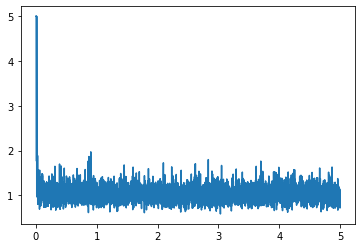

In [53]:
plt.plot(x, y)
plt.savefig('rnn_training_hist.png')


In [ ]:
print(all_losses)

In [ ]:
with open("rnn_500_unigrams_losses.npy" , "wb") as f:
    np.save(f, all_losses)

In [ ]:
allRatings = []
userRatings = defaultdict(list)

for d in train:
    uid = d["user"]
    r = int(d['stars'])
    allRatings.append(r)
    userRatings[uid].append(r)

In [ ]:
globalAverage = sum(allRatings) / len(allRatings)
userAverage = {}
for u in userRatings:
    userAverage[u] = sum(userRatings[u]) / len(userRatings[u])
        
count = 0
total = 0
for d in val:
    uid = d["user"]
    if uid in userAverage:
        pred = userAverage[u]
    else:
        pred = globalAverage
    count += (pred - d["stars"]) ** 2
    total += 1

print(f"Baseline performance on val: {count/total}")

In [ ]:
rating_stars = {}
for d in train:
    r = int(d['stars'])
    rating_stars[r] = 0
print(rating_stars)